# About

This is an experiment of flat PID for decay $B\to D*\tau\nu$. Details of [samples]( https://indico.cern.ch/event/556948/contributions/2247523/attachments/1312518/1964593/Muons_RDst.pdf)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import root_numpy

### define plot functions for roc and flatness

In [3]:
from rep.utils import get_efficiencies, weighted_quantile
from rep.plotting import ErrorPlot
from sklearn.metrics import roc_curve, roc_auc_score


def plot_flatness(probs, spectator, weights=None, thresholds=[50, 70, 90], use_thresholds=False, 
                  mask=None, bins_number=20, ignored_sideband=0.00, 
                  spectator_name='momentum', mva_name='ProbNNmu'):
    thresholds_values = thresholds if use_thresholds else \
        [weighted_quantile(probs, sample_weight=weights, quantiles=1 - eff / 100.) for eff in thresholds]
    if mask is not None:
        probs = probs[mask]
        spectator = spectator[mask]
    if weights is None:
        weights = numpy.ones(len(probs))
        
    eff = get_efficiencies(probs, spectator, sample_weight=weights,
                           bins_number=bins_number, errors=True, ignored_sideband=ignored_sideband,
                           thresholds=thresholds_values)
    for thr in thresholds_values:
        eff[thr] = (eff[thr][0], 100*numpy.array(eff[thr][1]), 100*numpy.array(eff[thr][2]), eff[thr][3])
    plot_fig = ErrorPlot(eff)
    plot_fig.xlabel = '{}'.format(spectator_name)
    plot_fig.ylabel = 'Efficiency'
    plot_fig.title = '{}'.format(mva_name)
    plot_fig.ylim = (0, 100)
    plot_fig.plot(fontsize=22)
    plt.xticks(fontsize=12), plt.yticks(fontsize=12)
    plt.legend(['Global Eff {}%'.format(thr) for thr in thresholds], 
               loc='lower right', fontsize=18, framealpha=0.5)
    plt.xlim(0,)

    
def plot_roc(labels, probs, weights, name='ProbNNmu'):
    fpr, tpr, _ = roc_curve(labels, probs, sample_weight=weights)
    plt.grid()
    auc = roc_auc_score(labels, probs, sample_weight=weights) * 100
    plot(tpr, 1 - fpr, linewidth=2, label='{} %1.2f'.format(name) %auc)
    xlim(0.7, 1)
    ylim(0.3, 1)
    legend()

# Define features

* `isMuonTight` is absent, take `mu_isMuonTight` 
* as current ProbNN take `mu_ProbNNmu` (baseline to compare flatness and quality)

In [4]:
features = ['TrackChi2PerDof', 'TrackP', 'TrackPt', 'TrackNumDof', 'TrackLikelihood', 'TrackFitTNDoF', 
            'TrackGhostProbability', 'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 
            'BremPIDe', 'InAccPrs', 'InAccBrem', 'PrsPIDe', 
            'MuonBkgLL', 'VeloCharge', 'MuonMuLL', 'mu_isMuonTight',
            'RichUsedAero', 'RichAboveMuThres', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 
            'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveKaThres',  'RichDLLe', 'InAccEcal', 'InAccHcal', 'MuonNShared', 
            'EcalPIDe', 'HcalPIDmu', 'HcalPIDe']
additional_features = ['mu_ProbNNmu']
features = list(numpy.sort(features))

# Read datasets

In [5]:
signal_data = pandas.DataFrame(root_numpy.root2array('../data/forPID/signal.root', 
                                                     branches=features + additional_features))
bck_data = pandas.DataFrame(root_numpy.root2array('../data/forPID/bkg_weighted.root', 
                                                  branches=features + additional_features))
bck_weight = root_numpy.root2array('../data/forPID/bkg_weighted.root', branches='bkgWeight')

### define data

In [6]:
bck_data['target'] = 0
bck_data['weight'] = bck_weight
signal_data['target'] = 1
signal_data['weight'] = 1

data = pandas.concat([signal_data, bck_data])

# Current ProbNNmu

In [7]:
# take threshould with 90% signal efficiency
threshold_ProbNN = weighted_quantile(data.loc[data.target == 1, 'mu_ProbNNmu'], quantiles=0.1)

### Singal flatness
Here, global efficiency is taken for the full signal dataset, the corresponding threshold is found and applyed to the necessary range of P/Pt.

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


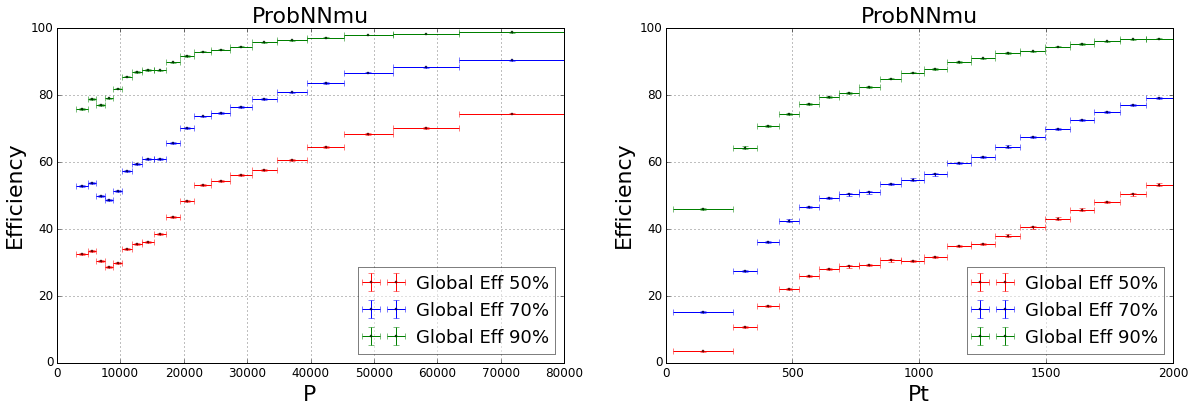

In [8]:
mask = data.target == 1

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_flatness(data.loc[mask, 'mu_ProbNNmu'].values, data.loc[mask, 'TrackP'].values,
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000)
plt.subplot(1, 2, 2)
plot_flatness(data.loc[mask, 'mu_ProbNNmu'].values, data.loc[mask, 'TrackPt'].values,
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000)

### Background flatness (MisID flatness)

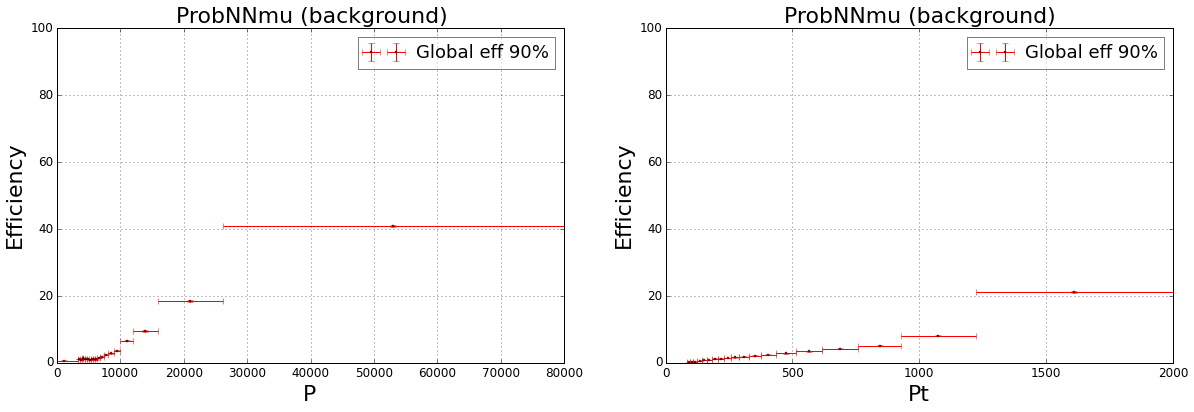

In [9]:
mask = (data.target == 0)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_flatness(data.loc[mask, 'mu_ProbNNmu'].values, data.loc[mask, 'TrackP'].values,
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000, 
              thresholds=[threshold_ProbNN], use_thresholds=True, mva_name='ProbNNmu (background)')
legend(['Global eff 90%'], loc='best', fontsize=18, framealpha=0.5)
plt.subplot(1, 2, 2)
plot_flatness(data.loc[mask, 'mu_ProbNNmu'].values, data.loc[mask, 'TrackPt'].values,
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000,
              thresholds=[threshold_ProbNN], use_thresholds=True, mva_name='ProbNNmu (background)')
legend(['Global eff 90%'], loc='best', fontsize=18, framealpha=0.5)

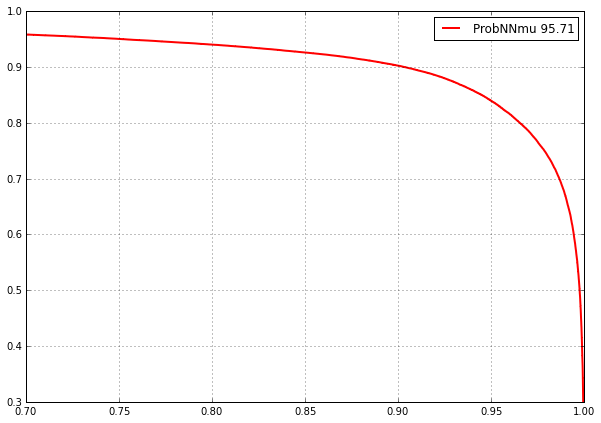

In [10]:
plt.figure(figsize=(10, 7))
plot_roc(data.target, data.mu_ProbNNmu, data.weight, name='ProbNNmu')

# Flatness experiments

Use 2-folding scheme to evaluate method on the full samples and then add to the root files

In [11]:
from losses import BinFlatnessLossFunctionPercentile, SumFlatLossFunction
from losses import SumFlatLossFunctionSpeedup, OneDimensionalFlatnessLossFunction, AdaLossFunction
from decisiontrain import DecisionTrainClassifier
from rep.metaml import FoldingClassifier
from rep.estimators import SklearnClassifier

In [12]:
len(data), sum(data.target == 1), sum(data.target == 0)

(936647, 601584, 335063)

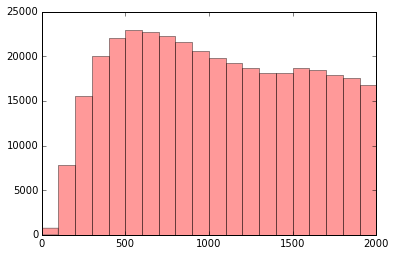

In [13]:
hist(data.loc[data.target == 1, 'TrackPt'], bins=20, alpha=0.4, range=(0, 2000))
pass

In [14]:
sum(data.loc[data.target == 1, 'TrackPt'] < 100)

733

## Linear combination of Flatness losses for P and Pt

In [15]:
%%time

loss_linear_combination = SumFlatLossFunction(
    BinFlatnessLossFunctionPercentile(uniform_features=['TrackPt'], uniform_label=1, power=2,
                                      n_bins=200, fl_coefficient=40),
    BinFlatnessLossFunctionPercentile(uniform_features=['TrackP'], uniform_label=1, power=2, 
                                      n_bins=200, fl_coefficient=40))
    
flatness_p_pt = FoldingClassifier(SklearnClassifier(
        DecisionTrainClassifier(n_threads=12,
                                loss=loss_linear_combination,
                                n_estimators=10000, learning_rate=0.05, 
                                train_features=list(set(features) - {'TrackP', 'TrackPt'}))), random_state=11)
                                  
flatness_p_pt.fit(data, data.target, data.weight)

CPU times: user 1h 38s, sys: 4.49 s, total: 1h 43s
Wall time: 38min 29s


In [16]:
from hep_ml.metrics import KnnBasedCvM, BinBasedCvM
report = flatness_p_pt.test_on(data, data.target, data.weight)
lc = report.learning_curve(BinBasedCvM(['TrackPt', 'TrackP'], 1, n_bins=30))
lc_p = report.learning_curve(BinBasedCvM(['TrackP'], 1, n_bins=30))
lc_pt = report.learning_curve(BinBasedCvM(['TrackPt'], 1, n_bins=30))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


#### cvm dependence on number of iterations

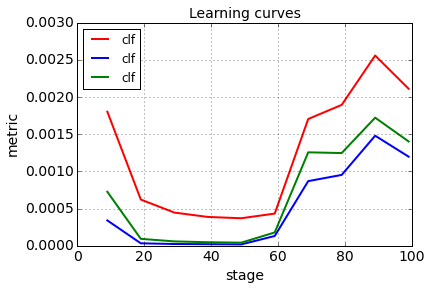

In [17]:
lc.plot()
lc_p.plot()
lc_pt.plot()

In [18]:
flatness_p_pt.estimators[0].clf.estimators = flatness_p_pt.estimators[0].clf.estimators[:6000]
flatness_p_pt.estimators[1].clf.estimators = flatness_p_pt.estimators[1].clf.estimators[:6000]

In [19]:
probs_flat = flatness_p_pt.predict_proba(data)[:, 1]

KFold prediction using folds column


In [20]:
roc_auc_score(data.target, probs_flat, sample_weight=data.weight)

0.96552388067278061

#### comparison with the base ProbNN

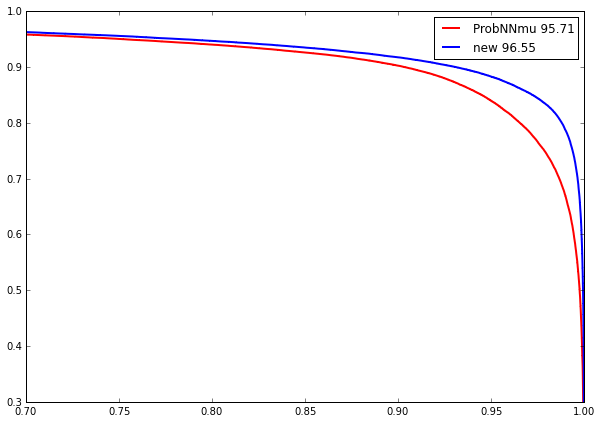

In [21]:
plt.figure(figsize=(10, 7))
plot_roc(data.target, data.mu_ProbNNmu, data.weight, name='ProbNNmu')
plot_roc(data.target, probs_flat, data.weight, name='new')
xlim(0.7, 1)
ylim(0.3, 1)
legend(loc='best')

### Singal flatness
Here, global efficiency is taken for the full signal dataset, the corresponding threshold is found and applyed to the necessary range of P/Pt.

(40, 100)

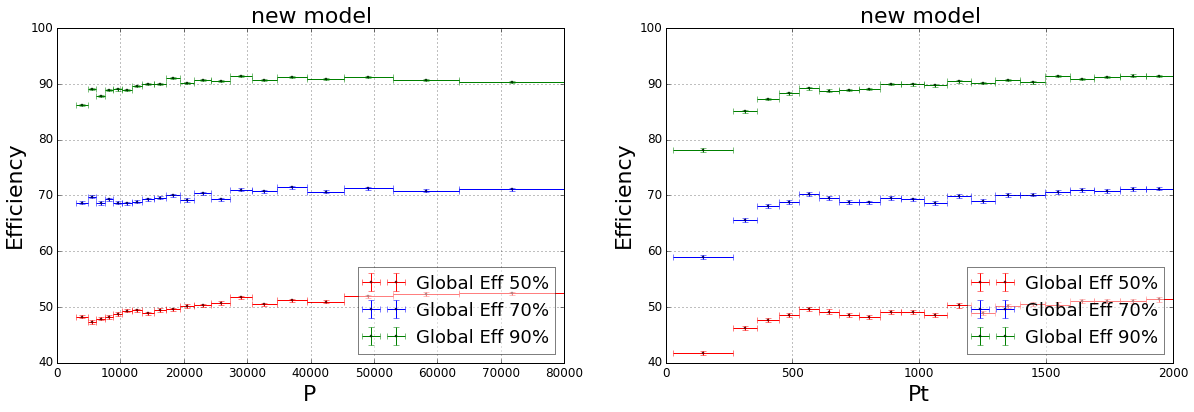

In [22]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
mask = (data.target == 1)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20,  mva_name='new model',
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000)
ylim(40, 100)
plt.subplot(1, 2, 2)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20, mva_name='new model',
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000)
ylim(40, 100)

(40, 100)

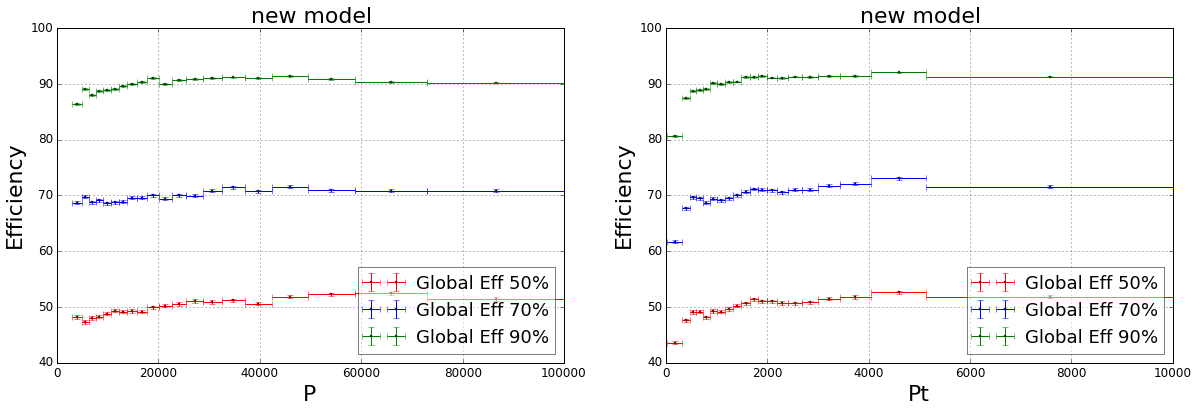

In [23]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
mask = (data.target == 1)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, mva_name='new model',
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 100000)
ylim(40, 100)
plt.subplot(1, 2, 2)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20, mva_name='new model',
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 10000)
ylim(40, 100)

### Background flatness (MisID flatness)

In [24]:
threshold_p_pt = weighted_quantile(probs_flat[data.target.values == 1], quantiles=0.1)

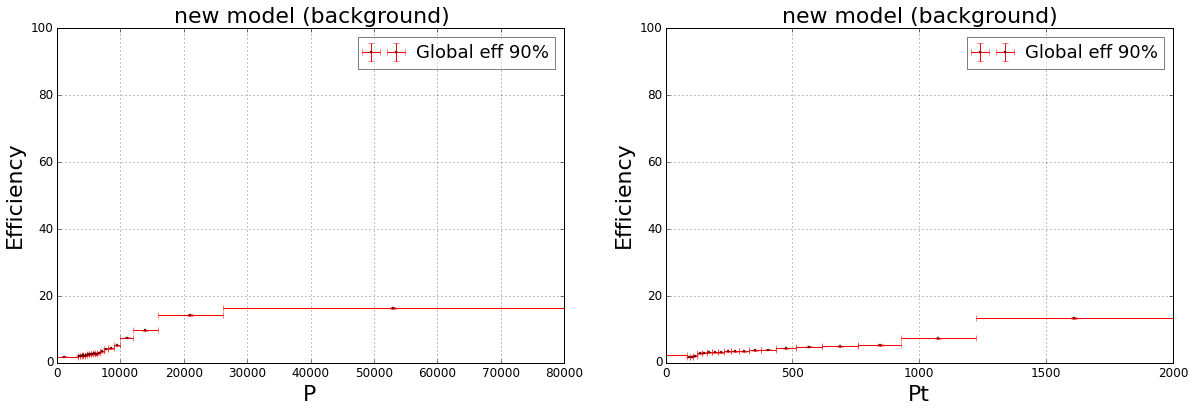

In [25]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
mask = (data.target == 0)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackP'].values,
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000, 
              thresholds=[threshold_p_pt], use_thresholds=True, mva_name='new model (background)')
legend(['Global eff 90%'], loc='best', fontsize=18, framealpha=0.5)
plt.subplot(1, 2, 2)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackPt'].values,
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000,
              thresholds=[threshold_p_pt], use_thresholds=True, mva_name='new model (background)')
legend(['Global eff 90%'], loc='best', fontsize=18, framealpha=0.5)

## 2d FL loss

In [26]:
%%time

loss_2d = BinFlatnessLossFunctionPercentile(uniform_features=['TrackPt', 'TrackP'], uniform_label=1, n_bins=30, 
                                            fl_coefficient=20)

flatness_2d = FoldingClassifier( SklearnClassifier(
        DecisionTrainClassifier(n_threads=12, loss=loss_2d,
                                n_estimators=10000, learning_rate=0.05, 
                                train_features=list(set(features) - {'TrackP', 'TrackPt'}))), random_state=11)
flatness_2d.fit(data, data.target, data.weight)

CPU times: user 48min 41s, sys: 3.74 s, total: 48min 45s
Wall time: 26min 32s


In [27]:
report = flatness_2d.test_on(data, data.target, data.weight)
lc = report.learning_curve(BinBasedCvM(['TrackPt', 'TrackP'], 1, n_bins=30))
lc_p = report.learning_curve(BinBasedCvM(['TrackP'], 1, n_bins=30))
lc_pt = report.learning_curve(BinBasedCvM(['TrackPt'], 1, n_bins=30))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


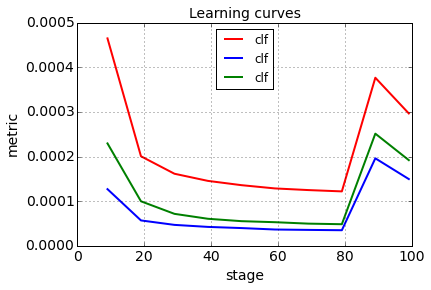

In [28]:
lc.plot()
lc_p.plot()
lc_pt.plot()

In [29]:
flatness_2d.estimators[0].clf.estimators = flatness_2d.estimators[0].clf.estimators[:8000]
flatness_2d.estimators[1].clf.estimators = flatness_2d.estimators[1].clf.estimators[:8000]

In [30]:
probs_flat2d = flatness_2d.predict_proba(data)[:, 1]

KFold prediction using folds column


In [31]:
roc_auc_score(data.target, probs_flat2d, sample_weight=data.weight)

0.96731503268463048

### Singal flatness
Here, global efficiency is taken for the full signal dataset, the corresponding threshold is found and applyed to the necessary range of P/Pt.

(40, 100)

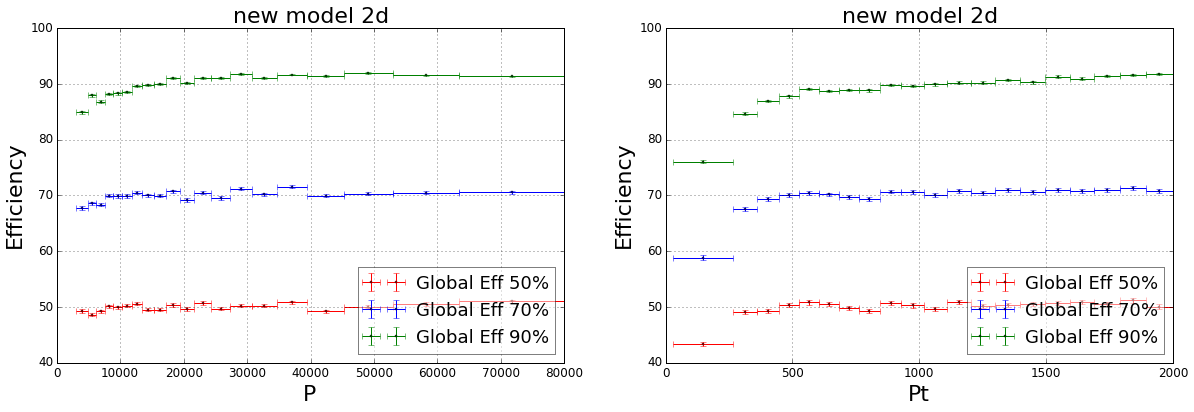

In [32]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
mask = (data.target == 1)
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, mva_name='new model 2d',
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000)
ylim(40, 100)
plt.subplot(1, 2, 2)
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20, mva_name='new model 2d',
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000)
ylim(40, 100)

(40, 100)

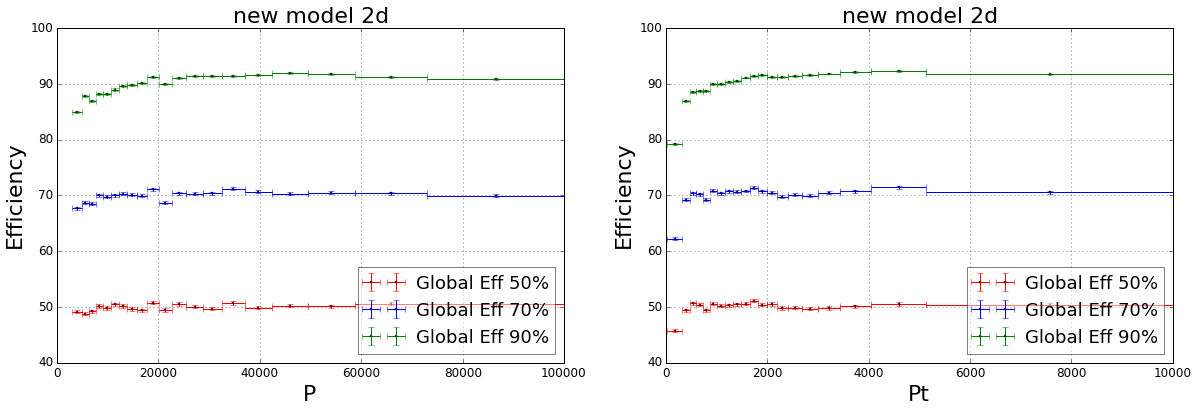

In [33]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
mask = (data.target == 1)
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, mva_name='new model 2d',
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 100000)
ylim(40, 100)
plt.subplot(1, 2, 2)
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20, mva_name='new model 2d',
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 10000)
ylim(40, 100)

### Background flatness (MisID flatness)

In [34]:
threshold_2d = weighted_quantile(probs_flat2d[data.target.values == 1], quantiles=0.1)

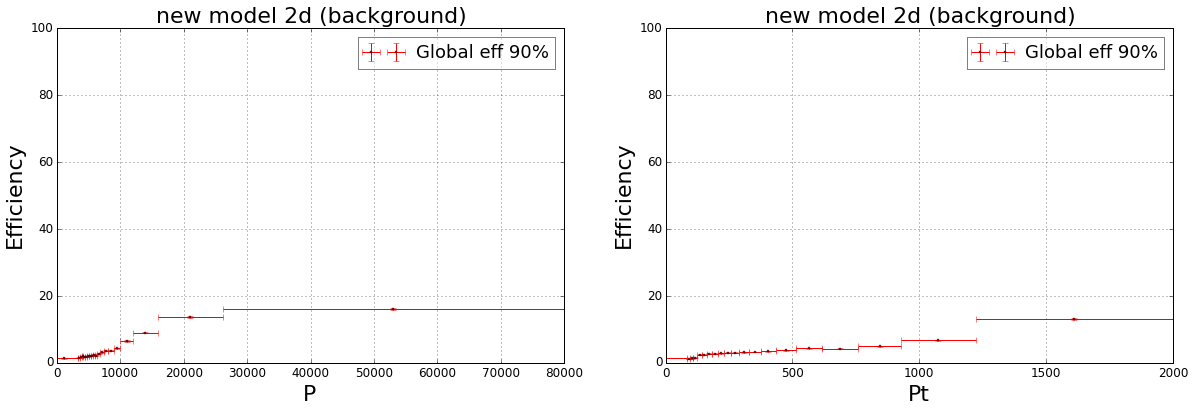

In [35]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
mask = (data.target == 0)
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackP'].values,
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000, 
              thresholds=[threshold_2d], use_thresholds=True, mva_name='new model 2d (background)')
legend(['Global eff 90%'], loc='best', fontsize=18, framealpha=0.5)
plt.subplot(1, 2, 2)
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackPt'].values,
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000,
              thresholds=[threshold_2d], use_thresholds=True, mva_name='new model 2d (background)')
legend(['Global eff 90%'], loc='best', fontsize=18, framealpha=0.5)

--------------------------------------------------

# Final comparison of models

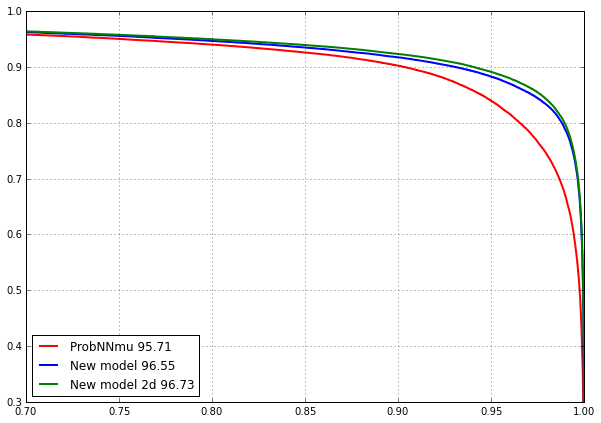

In [36]:
plt.figure(figsize=(10, 7))
plot_roc(data.target, data.mu_ProbNNmu, data.weight, name='ProbNNmu')
plot_roc(data.target, probs_flat, data.weight, name='New model')
plot_roc(data.target, probs_flat2d, data.weight, name='New model 2d')
legend(loc='best')

### Signal efficiency along P, Pt

(70, 100)

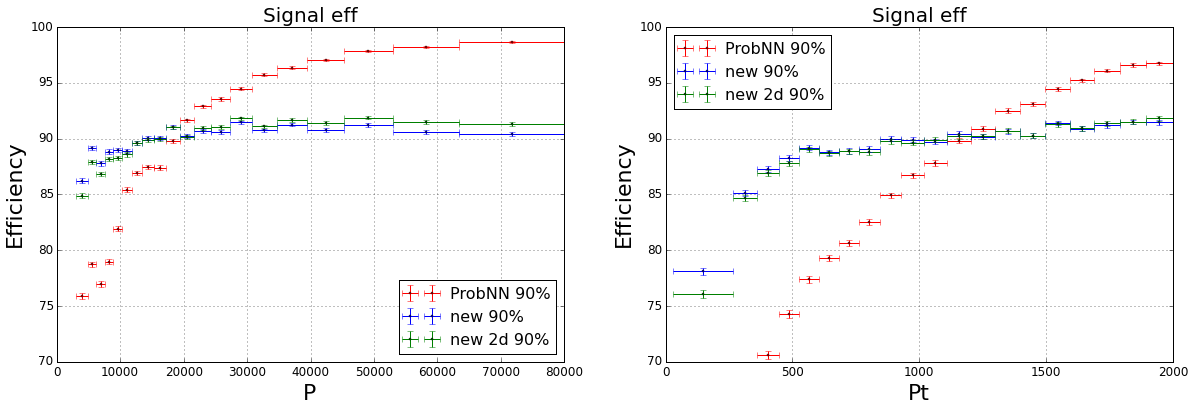

In [37]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
mask = (data.target == 1)
plot_flatness(data.mu_ProbNNmu.values[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, thresholds=[90], 
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, 
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000, thresholds=[90])
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, 
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000, thresholds=[90])
legend(['ProbNN 90%', 'new 90%', 'new 2d 90%'], loc='best', fontsize=16)
title('Signal eff', fontsize=20)
ylim(70, 100)
plt.subplot(1, 2, 2)
plot_flatness(data.mu_ProbNNmu.values[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20, thresholds=[90],
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20,
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000, thresholds=[90])
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20,
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000, thresholds=[90])
legend(['ProbNN 90%', 'new 90%', 'new 2d 90%'], loc='best', fontsize=16)
title('Signal eff', fontsize=20)
ylim(70, 100)

### Bck efficiency (MisId) along P, Pt

(0, 30)

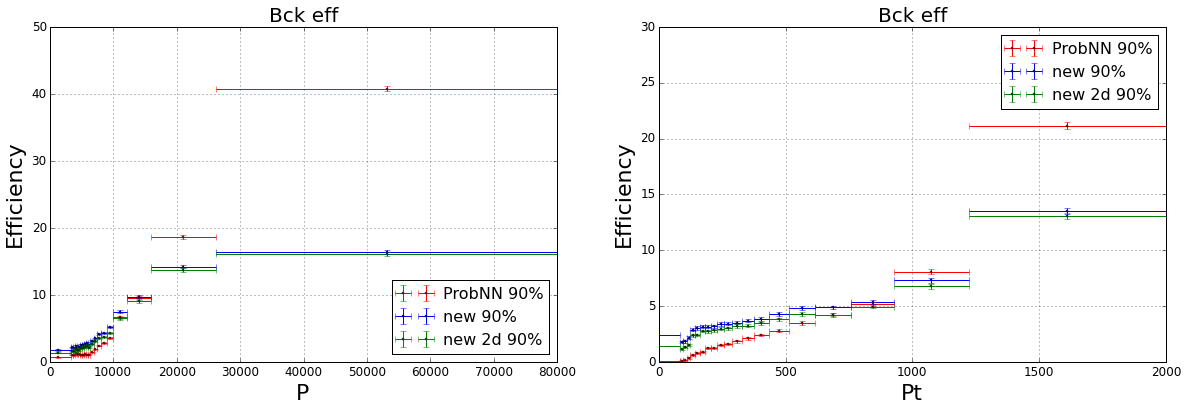

In [38]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
mask = (data.target == 0)
plot_flatness(data.mu_ProbNNmu.values[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, thresholds=[threshold_ProbNN], 
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000,
              use_thresholds=True)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, use_thresholds=True,
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000, thresholds=[threshold_p_pt])
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackP'].values, bins_number=20, use_thresholds=True, 
              spectator_name='P', mask=data.loc[mask, 'TrackP'].values < 80000, thresholds=[threshold_2d])
legend(['ProbNN 90%', 'new 90%', 'new 2d 90%'], loc='best', fontsize=16)
title('Bck eff', fontsize=20)
ylim(0, 50)
plt.subplot(1, 2, 2)
plot_flatness(data.mu_ProbNNmu.values[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20,
              thresholds=[threshold_ProbNN], use_thresholds=True, 
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000)
plot_flatness(probs_flat[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20, use_thresholds=True, 
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000, thresholds=[threshold_p_pt])
plot_flatness(probs_flat2d[mask.values], data.loc[mask, 'TrackPt'].values, bins_number=20, use_thresholds=True,
              spectator_name='Pt', mask=data.loc[mask, 'TrackPt'].values < 2000, thresholds=[threshold_2d])
legend(['ProbNN 90%', 'new 90%', 'new 2d 90%'], loc='best', fontsize=16)
title('Bck eff', fontsize=20)
ylim(0, 30)

In [42]:
new_column = numpy.array(probs_flat[data.target.values == 1], dtype=[('PIDflat', 'f8')])
root_numpy.array2root(new_column, '../data/forPID/signal.root', treename='DecayTree')

new_column = numpy.array(probs_flat2d[data.target.values == 1], dtype=[('PIDflat2d', 'f8')])
root_numpy.array2root(new_column, '../data/forPID/signal.root', treename='DecayTree')

In [43]:
new_column = numpy.array(probs_flat[data.target.values == 0], dtype=[('PIDflat', 'f8')])
root_numpy.array2root(new_column, '../data/forPID/bkg_weighted.root', treename='DecayTree')

new_column = numpy.array(probs_flat2d[data.target.values == 0], dtype=[('PIDflat2d', 'f8')])
root_numpy.array2root(new_column, '../data/forPID/bkg_weighted.root', treename='DecayTree')